In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import glob
%cd ../

/home/krong/Documents/classes/SP/final/AdaptiveAccompaniment


In [15]:
hop_length = 4096

In [2]:
fileId_path = "experiments/fileIds.pkl"
queryInfo_path = "experiments/queryInfo.pkl"
timeData_path = "experiments/timeData.pkl"
audioFiles_path = "experiments/audioFiles.pkl"
with open(fileId_path, 'rb') as f:
    fileIds=pkl.load(f)
with open(queryInfo_path, 'rb') as f:
    queryInfo=pkl.load(f)
with open(timeData_path, 'rb') as f:
    timeData=pkl.load(f)
with open(audioFiles_path, 'rb') as f:
    audioFiles=pkl.load(f)

In [3]:
def readHypFiles(hypdir):
    
    for hypfile in sorted(glob.glob("{}/*.hyp".format(hypdir))):
        print(hypfile)
        with open(hypfile, "rb") as f:
            yield(pkl.load(f))
    

In [4]:
def evaluateBeatLevel(tf, segment_predict, solo_name, ref_name, sr=22050):
    # Only evaluate within segments
    diffs = []
    pieceName = solo_name.split('_')[0]
    gt_segments = queryInfo[pieceName]
    annotated_beats = list(timeData[ref_name].keys())
    for idx,beats in enumerate(gt_segments):
        beat1 = beats.split(',')[0][1:]
        beat2 = beats.split(',')[1][:-1]
        idx1 = annotated_beats.index(beat1)
        idx2 = annotated_beats.index(beat2)
        #offset = int(timeData[ref_name][beat1]*sr)-segment_predict[idx][0]
        base_time = tf[segment_predict[idx][0]]
        #base_time = tf[int(timeData[ref_name][beat1]*sr)]
        #print(offset)
        
        new_times = {}
        for i in range(idx1,idx2+1):
            key = annotated_beats[i]
            sample = tf[int(timeData[ref_name][key]*sr)]
            new_time = sample-base_time
            new_times[key]=new_time
            
        gt_beats = list(timeData[solo_name].keys())
        gt_base_time=timeData[solo_name][beat1]
        prev = 0
        prevgt = 0
        for idx, key in enumerate(new_times):
            if key in gt_beats:
                gt_time = (timeData[solo_name][key]-gt_base_time)*sr
                pred_time = new_times[key]
                #f idx != 0:
                #   print("diff",gt_time-prevgt, pred_time-prev)
                prev = pred_time
                prevgt = gt_time
                #rint(gt_time, pred_time)
                diffs.append(np.abs(gt_time-pred_time))
    return diffs

In [5]:
def evaluateBeatLevelFirst(tf, segment_predict, solo_name, ref_name, sr=22050):
    # Only evaluate within segments
    diffs = []
    pieceName = solo_name.split('_')[0]
    gt_segments = queryInfo[pieceName]
    annotated_beats = list(timeData[ref_name].keys())
    for idx,beats in enumerate(gt_segments):
        if idx!=1:
            continue
        beat1 = beats.split(',')[0][1:]
        beat2 = beats.split(',')[1][:-1]
        idx1 = annotated_beats.index(beat1)
        idx2 = annotated_beats.index(beat2)
        offset = int(timeData[ref_name][beat1]*sr)-segment_predict[idx][0]
        base_time = tf[segment_predict[idx][0]]
        
        new_times = {}
        for i in range(idx1,idx2+1):
            key = annotated_beats[i]
            sample = tf[int(timeData[ref_name][key]*sr)]
            new_time = sample-base_time
            new_times[key]=new_time
            
        gt_beats = list(timeData[solo_name].keys())
        gt_base_time=timeData[solo_name][beat1]
        prev = 0
        prevgt = 0
        for idx, key in enumerate(new_times):
            if key in gt_beats:
                gt_time = (timeData[solo_name][key]-gt_base_time)*sr
                pred_time = new_times[key]
                #f idx != 0:
                #   print("diff",gt_time-prevgt, pred_time-prev)
                prev = pred_time
                prevgt = gt_time
                #rint(gt_time, pred_time)
                diffs.append(np.abs(gt_time-pred_time))
    return diffs

In [6]:
def evaluateSegmentLevel(segment_predict, solo_name, ref_name, sr=22050):
    pieceName = solo_name.split('_')[0]
    gt_segments = queryInfo[pieceName]
    gt_samples = []
    diffs = []
    for beats in gt_segments:
        beat1 = beats.split(',')[0][1:]
        beat2 = beats.split(',')[1][:-1]
        sample1 = timeData[ref_name][beat1]*sr
        sample2 = timeData[ref_name][beat2]*sr
        gt_samples.append((sample1, sample2))
    for idx,segment in enumerate(segment_predict):
        seg0 = segment[0]
        seg1 = segment[1]
        diff0 = np.abs(gt_samples[idx][0]-seg0)
        diff1 = np.abs(gt_samples[idx][1]-seg1)
        diffs.append(diff0)
        diffs.append(diff1)
        if diff0 > 22050:
            print(solo_name, ref_name)
            print(gt_samples[idx][0],seg0)
        if diff1 > 22050:
            print(ref_name, solo_name)
            print(gt_samples[idx][1],seg1)
        #print((gt_samples[idx][0]-seg0)/(sr*sr))
    return diffs, gt_samples, segment_predict

In [16]:
def evaluate(hypdir, sr=22050):
    
    times = []
    segment_tolerances =[1, 0.5, 0.25]
    segment_total = np.zeros(len(segment_tolerances))
    segment_correct = np.zeros(len(segment_tolerances))
    
    beat_tolerances =np.arange(0.0, 2, 0.025)
    #beat_tolerances=[0.25]
    beat_total = np.zeros(len(beat_tolerances))
    beat_correct = np.zeros(len(beat_tolerances))
    beat_totalFirst = np.zeros(len(beat_tolerances))
    beat_correctFirst = np.zeros(len(beat_tolerances))
    for solo_name, ref_name, tf, segment_predict, time_taken in readHypFiles(hypdir):
        tf = np.array(tf)
        segment_predict = np.array(segment_predict)*hop_length
        #print(segment_predict)
        segment_diffs, gt_samples, segment_predict = evaluateSegmentLevel(segment_predict, solo_name, ref_name)
        if any(tf!=None):
            beat_diffs = evaluateBeatLevel(tf, segment_predict, solo_name, ref_name)
            beat_diffsFirst = evaluateBeatLevelFirst(tf, segment_predict, solo_name, ref_name)
            #beat_diffs = evaluateDiffLevel(tf, segment_predict, solo_name, ref_name)
            beat_diffs =(np.array(beat_diffs)/sr)
            beat_diffsFirst =(np.array(beat_diffsFirst)/sr)
        segment_diffs =np.array(segment_diffs)/sr
        times.append(time_taken)
        
        #Update Segment Level Accuracy
        for idx, tolerance in enumerate(segment_tolerances):
            segment_correct[idx] += np.sum(np.where(segment_diffs<tolerance, 1, 0))
            segment_total[idx]+=len(segment_diffs)
            
            
        if any(tf!=None):
            #Update Beat Level Accuracy
            for idx, tolerance in enumerate(beat_tolerances):
                beat_correct[idx] += np.sum(np.where(beat_diffs<tolerance, 1, 0))
                beat_total[idx]+=len(beat_diffs)

            #Update First Beat Level Accuracy
            for idx, tolerance in enumerate(beat_tolerances):
                beat_correctFirst[idx] += np.sum(np.where(beat_diffsFirst<tolerance, 1, 0))
                beat_totalFirst[idx]+=len(beat_diffsFirst)
    print("hop_length", hop_length)
    print(segment_correct/segment_total)
    print(beat_correct/beat_total)
    return segment_correct/segment_total, beat_correct/beat_total     

In [9]:
seg_accuracy, beat_accuracy = evaluate("experiments/exp_new_tf")
#seg_accuracy, beat_accuracy = evaluate("baselines/debug2")

experiments/exp_new_tf/p1s_perf12-p1f_perf16.hyp
experiments/exp_new_tf/p1s_perf12-p1f_perf2.hyp
p1f_perf2 p1s_perf12
3928012.66666305 3983360
experiments/exp_new_tf/p1s_perf12-p1f_perf23.hyp
p1f_perf23 p1s_perf12
3797529.00000075 3849216
experiments/exp_new_tf/p1s_perf12-p1f_perf24.hyp
experiments/exp_new_tf/p1s_perf12-p1f_perf6.hyp
p1f_perf6 p1s_perf12
3799099.9999963506 3838976
experiments/exp_new_tf/p1s_perf2-p1f_perf16.hyp
experiments/exp_new_tf/p1s_perf2-p1f_perf2.hyp
experiments/exp_new_tf/p1s_perf2-p1f_perf23.hyp
experiments/exp_new_tf/p1s_perf2-p1f_perf24.hyp
experiments/exp_new_tf/p1s_perf2-p1f_perf6.hyp
experiments/exp_new_tf/p1s_perf25-p1f_perf16.hyp
p1f_perf16 p1s_perf25
3888554.6666641505 3974144
experiments/exp_new_tf/p1s_perf25-p1f_perf2.hyp
p1f_perf2 p1s_perf25
3928012.66666305 4083712
experiments/exp_new_tf/p1s_perf25-p1f_perf23.hyp
p1f_perf23 p1s_perf25
3797529.00000075 3882496
experiments/exp_new_tf/p1s_perf25-p1f_perf24.hyp
p1f_perf24 p1s_perf25
3493643.6666648993 

/home/krong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


experiments/exp_new_tf/p2s_perf17-p2f_perf14.hyp
experiments/exp_new_tf/p2s_perf17-p2f_perf18.hyp
p2f_perf18 p2s_perf17
1304883.6666684 1280000
p2f_perf18 p2s_perf17
5317967.9999963995 5291008
experiments/exp_new_tf/p2s_perf17-p2f_perf20.hyp
experiments/exp_new_tf/p2s_perf17-p2f_perf5.hyp
p2f_perf5 p2s_perf17
4821841.6666623 4788736
experiments/exp_new_tf/p2s_perf4-p2f_perf1.hyp
p2f_perf1 p2s_perf4
1345851.3333310501 1297408
experiments/exp_new_tf/p2s_perf4-p2f_perf14.hyp
experiments/exp_new_tf/p2s_perf4-p2f_perf18.hyp
p2f_perf18 p2s_perf4
5317967.9999963995 5287424
experiments/exp_new_tf/p2s_perf4-p2f_perf20.hyp
experiments/exp_new_tf/p2s_perf4-p2f_perf5.hyp
p2f_perf5 p2s_perf4
3153074.3333375994 3209216
p2f_perf5 p2s_perf4
4821841.6666623 4794880
experiments/exp_new_tf/p2s_perf8-p2f_perf1.hyp
p2f_perf1 p2s_perf8
1345851.3333310501 1321984
experiments/exp_new_tf/p2s_perf8-p2f_perf14.hyp
p2f_perf14 p2s_perf8
5230606.3333377 5207040
experiments/exp_new_tf/p2s_perf8-p2f_perf18.hyp
p2f_pe

/home/krong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


experiments/exp_new_tf/p3s_perf22-p3f_perf16.hyp
experiments/exp_new_tf/p3s_perf22-p3f_perf2.hyp
experiments/exp_new_tf/p3s_perf22-p3f_perf23.hyp
experiments/exp_new_tf/p3s_perf22-p3f_perf24.hyp
experiments/exp_new_tf/p3s_perf9-p3f_perf11.hyp
experiments/exp_new_tf/p3s_perf9-p3f_perf16.hyp
experiments/exp_new_tf/p3s_perf9-p3f_perf2.hyp
p3s_perf9 p3f_perf2
3455676.3333372 3425280
experiments/exp_new_tf/p3s_perf9-p3f_perf23.hyp
experiments/exp_new_tf/p3s_perf9-p3f_perf24.hyp
experiments/exp_new_tf/p4s_perf15-p4f_perf13.hyp
p4s_perf15 p4f_perf13
204395.33332680003 1395712
p4f_perf13 p4s_perf15
1369877.33333535 2529792
experiments/exp_new_tf/p4s_perf15-p4f_perf16.hyp
p4s_perf15 p4f_perf16
18244.666661550003 1144832
p4f_perf16 p4s_perf15
1116649.33333275 2265088
experiments/exp_new_tf/p4s_perf15-p4f_perf2.hyp
experiments/exp_new_tf/p4s_perf2-p4f_perf13.hyp
p4s_perf2 p4f_perf13
204395.33332680003 1395200
p4f_perf13 p4s_perf2
1369877.33333535 2530304
experiments/exp_new_tf/p4s_perf2-p4f_perf1

In [10]:
seg_accuracy, beat_accuracy = evaluate("experiments/exp_old_tf")

experiments/exp_old_tf/p1s_perf12-p1f_perf16.hyp
experiments/exp_old_tf/p1s_perf12-p1f_perf2.hyp
p1f_perf2 p1s_perf12
3928012.66666305 3983360
experiments/exp_old_tf/p1s_perf12-p1f_perf23.hyp
p1f_perf23 p1s_perf12
3797529.00000075 3849216
experiments/exp_old_tf/p1s_perf12-p1f_perf24.hyp
experiments/exp_old_tf/p1s_perf12-p1f_perf6.hyp
p1f_perf6 p1s_perf12
3799099.9999963506 3838976
experiments/exp_old_tf/p1s_perf2-p1f_perf16.hyp
experiments/exp_old_tf/p1s_perf2-p1f_perf2.hyp
experiments/exp_old_tf/p1s_perf2-p1f_perf23.hyp
experiments/exp_old_tf/p1s_perf2-p1f_perf24.hyp
experiments/exp_old_tf/p1s_perf2-p1f_perf6.hyp
experiments/exp_old_tf/p1s_perf25-p1f_perf16.hyp
p1f_perf16 p1s_perf25
3888554.6666641505 3974144
experiments/exp_old_tf/p1s_perf25-p1f_perf2.hyp
p1f_perf2 p1s_perf25
3928012.66666305 4083712
experiments/exp_old_tf/p1s_perf25-p1f_perf23.hyp
p1f_perf23 p1s_perf25
3797529.00000075 3882496
experiments/exp_old_tf/p1s_perf25-p1f_perf24.hyp
p1f_perf24 p1s_perf25
3493643.6666648993 

/home/krong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


experiments/exp_old_tf/p2s_perf17-p2f_perf18.hyp
p2f_perf18 p2s_perf17
1304883.6666684 1280000
p2f_perf18 p2s_perf17
5317967.9999963995 5291008
experiments/exp_old_tf/p2s_perf17-p2f_perf20.hyp
experiments/exp_old_tf/p2s_perf17-p2f_perf5.hyp
p2f_perf5 p2s_perf17
4821841.6666623 4788736
experiments/exp_old_tf/p2s_perf4-p2f_perf1.hyp
p2f_perf1 p2s_perf4
1345851.3333310501 1297408
experiments/exp_old_tf/p2s_perf4-p2f_perf14.hyp
experiments/exp_old_tf/p2s_perf4-p2f_perf18.hyp
p2f_perf18 p2s_perf4
5317967.9999963995 5287424
experiments/exp_old_tf/p2s_perf4-p2f_perf20.hyp
experiments/exp_old_tf/p2s_perf4-p2f_perf5.hyp
p2f_perf5 p2s_perf4
3153074.3333375994 3209216
p2f_perf5 p2s_perf4
4821841.6666623 4794880
experiments/exp_old_tf/p2s_perf8-p2f_perf1.hyp
p2f_perf1 p2s_perf8
1345851.3333310501 1321984
experiments/exp_old_tf/p2s_perf8-p2f_perf14.hyp
p2f_perf14 p2s_perf8
5230606.3333377 5207040
experiments/exp_old_tf/p2s_perf8-p2f_perf18.hyp
p2f_perf18 p2s_perf8
1304883.6666684 1354752
p2f_perf18

/home/krong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


experiments/exp_old_tf/p3s_perf22-p3f_perf16.hyp
experiments/exp_old_tf/p3s_perf22-p3f_perf2.hyp
experiments/exp_old_tf/p3s_perf22-p3f_perf23.hyp
experiments/exp_old_tf/p3s_perf22-p3f_perf24.hyp
experiments/exp_old_tf/p3s_perf9-p3f_perf11.hyp
experiments/exp_old_tf/p3s_perf9-p3f_perf16.hyp
experiments/exp_old_tf/p3s_perf9-p3f_perf2.hyp
p3s_perf9 p3f_perf2
3455676.3333372 3425280
experiments/exp_old_tf/p3s_perf9-p3f_perf23.hyp
experiments/exp_old_tf/p3s_perf9-p3f_perf24.hyp
experiments/exp_old_tf/p4s_perf15-p4f_perf13.hyp
p4s_perf15 p4f_perf13
204395.33332680003 1395712
p4f_perf13 p4s_perf15
1369877.33333535 2529792
experiments/exp_old_tf/p4s_perf15-p4f_perf16.hyp
p4s_perf15 p4f_perf16
18244.666661550003 1144832
p4f_perf16 p4s_perf15
1116649.33333275 2265088
experiments/exp_old_tf/p4s_perf15-p4f_perf2.hyp
experiments/exp_old_tf/p4s_perf2-p4f_perf13.hyp
p4s_perf2 p4f_perf13
204395.33332680003 1395200
p4f_perf13 p4s_perf2
1369877.33333535 2530304
experiments/exp_old_tf/p4s_perf2-p4f_perf1

In [17]:
seg_accuracy, beat_accuracy = evaluate("experiments/exp_hop_4096")

experiments/exp_hop_4096/p1s_perf12-p1f_perf16.hyp
experiments/exp_hop_4096/p1s_perf12-p1f_perf2.hyp
p1f_perf2 p1s_perf12
3928012.66666305 3981312
experiments/exp_hop_4096/p1s_perf12-p1f_perf23.hyp
p1f_perf23 p1s_perf12
3797529.00000075 3846144
experiments/exp_hop_4096/p1s_perf12-p1f_perf24.hyp
experiments/exp_hop_4096/p1s_perf12-p1f_perf6.hyp
p1f_perf6 p1s_perf12
3799099.9999963506 3837952
experiments/exp_hop_4096/p1s_perf2-p1f_perf16.hyp
experiments/exp_hop_4096/p1s_perf2-p1f_perf2.hyp
experiments/exp_hop_4096/p1s_perf2-p1f_perf23.hyp
p1f_perf23 p1s_perf2
3797529.00000075 3850240
experiments/exp_hop_4096/p1s_perf2-p1f_perf24.hyp
experiments/exp_hop_4096/p1s_perf2-p1f_perf6.hyp
experiments/exp_hop_4096/p1s_perf25-p1f_perf16.hyp
p1f_perf16 p1s_perf25
3888554.6666641505 3981312
experiments/exp_hop_4096/p1s_perf25-p1f_perf2.hyp
p1f_perf2 p1s_perf25
3928012.66666305 4083712
experiments/exp_hop_4096/p1s_perf25-p1f_perf23.hyp
p1f_perf23 p1s_perf25
3797529.00000075 3878912
experiments/exp_ho

/home/krong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


experiments/exp_hop_4096/p2s_perf17-p2f_perf14.hyp
experiments/exp_hop_4096/p2s_perf17-p2f_perf18.hyp
p2s_perf17 p2f_perf18
354577.66666349996 1437696
p2f_perf18 p2s_perf17
1304883.6666684 2088960
p2f_perf18 p2s_perf17
3503504.66666445 3477504
p2f_perf18 p2s_perf17
5317967.9999963995 5287936
experiments/exp_hop_4096/p2s_perf17-p2f_perf20.hyp
p2f_perf20 p2s_perf17
1204930.9999986 1179648
p2s_perf17 p2f_perf20
2407497.33333795 2486272
experiments/exp_hop_4096/p2s_perf17-p2f_perf5.hyp
p2f_perf5 p2s_perf17
3153074.3333375994 3207168
p2f_perf5 p2s_perf17
4821841.6666623 4788224
experiments/exp_hop_4096/p2s_perf4-p2f_perf1.hyp
p2f_perf1 p2s_perf4
1345851.3333310501 1318912
p2f_perf1 p2s_perf4
5454163.0000053 5423104
experiments/exp_hop_4096/p2s_perf4-p2f_perf14.hyp
experiments/exp_hop_4096/p2s_perf4-p2f_perf18.hyp
p2s_perf4 p2f_perf18
354577.66666349996 839680
p2f_perf18 p2s_perf4
1304883.6666684 1777664
p2f_perf18 p2s_perf4
3503504.66666445 3469312
p2f_perf18 p2s_perf4
5317967.9999963995 52

/home/krong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


experiments/exp_hop_4096/p3s_perf22-p3f_perf16.hyp
experiments/exp_hop_4096/p3s_perf22-p3f_perf2.hyp
experiments/exp_hop_4096/p3s_perf22-p3f_perf23.hyp
p3s_perf22 p3f_perf23
3244856.33333925 3289088
experiments/exp_hop_4096/p3s_perf22-p3f_perf24.hyp
experiments/exp_hop_4096/p3s_perf9-p3f_perf11.hyp
experiments/exp_hop_4096/p3s_perf9-p3f_perf16.hyp
experiments/exp_hop_4096/p3s_perf9-p3f_perf2.hyp
p3s_perf9 p3f_perf2
3455676.3333372 3416064
experiments/exp_hop_4096/p3s_perf9-p3f_perf23.hyp
experiments/exp_hop_4096/p3s_perf9-p3f_perf24.hyp
experiments/exp_hop_4096/p4s_perf15-p4f_perf13.hyp
p4s_perf15 p4f_perf13
204395.33332680003 1396736
p4f_perf13 p4s_perf15
1369877.33333535 2539520
p4s_perf15 p4f_perf13
2562035.9999955003 2531328
experiments/exp_hop_4096/p4s_perf15-p4f_perf16.hyp
p4s_perf15 p4f_perf16
18244.666661550003 1146880
p4f_perf16 p4s_perf15
1116649.33333275 2260992
experiments/exp_hop_4096/p4s_perf15-p4f_perf2.hyp
p4f_perf2 p4s_perf15
2635371.33333705 2678784
experiments/exp_ho

In [81]:
seg_y = [0.85579196, 0.82624113, 0.1, 0.5248227,  0.06382979]
seg_x = [1,.5, 0.25, 0.125, 0.01]

['(1.1,12.3)', '(13.1,35.1)', '(35.3,57.3)', '(58.1,71.1)', '(71.3,80.1)']

In [11]:
beat_y = [0,        0.30652671, 0.4832388,  0.57694912, 0.63104207, 0.66693473,
 0.69330399, 0.71294337, 0.72754592, 0.73990519, 0.7513756,  0.76174553,
 0.77012613, 0.77660205, 0.78379751, 0.78993482, 0.79476001, 0.79844239,
 0.80220943, 0.80580716, 0.80864302, 0.81190214, 0.81499196, 0.81850504,
 0.8205367,  0.82239905, 0.82476932, 0.82752053, 0.82967917, 0.83188013,
 0.8340811,  0.83607043, 0.83772115, 0.83945653, 0.84144586, 0.84296961,
 0.84432405, 0.84580547, 0.84711758, 0.848599,   0.85003809, 0.85075764,
 0.85202743, 0.85333954, 0.85444002, 0.85562516, 0.85647168, 0.85736054,
 0.85850334, 0.85964615, 0.860535,   0.86104292, 0.8619741,  0.8627783,
 0.86366715, 0.86447135, 0.86544485, 0.86612207, 0.86701092, 0.86819606,
 0.86900025, 0.86976213, 0.870524,   0.87158216, 0.87234403, 0.87323288,
 0.87382545, 0.87437569, 0.87517989, 0.87581478, 0.87670363, 0.87750783,
 0.87839668, 0.87915855, 0.87949716, 0.88038602, 0.88140185, 0.88195209,
 0.88258698, 0.88296792]
beat_x = np.arange(0.05, 2, 0.05)

SyntaxError: invalid syntax (<ipython-input-11-3f804f170194>, line 1)

In [12]:
beat_y = beat_accuracy
beat_x = np.arange(0.05, 2, 0.05)

Text(0, 0.5, 'Error')

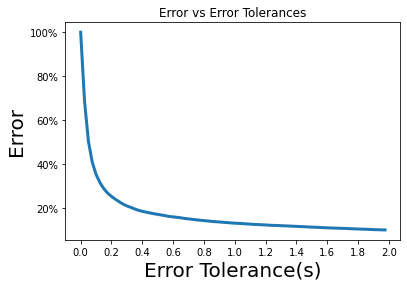

In [13]:
plt.title("Error vs Error Tolerances")
x=np.arange(0.0, 2, 0.025)
plt.rcParams.update({'font.size': 15})
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.plot(x, 1-np.array(beat_accuracy), linewidth=3)
plt.xticks(np.arange(min(x), max(x)+.1, 0.2))
plt.xlabel('Error Tolerance(s)', fontsize=20)
plt.ylabel('Error', fontsize=20)

In [65]:
queryInfo['p1s']

['(9.1,24.1)', '(29.1,36.1)', '(49.1,68.1)', '(68.1,95.1)', '(96.1,109.1)']

In [66]:
timeData['p1f_perf23']

{'1.1': 0.7393801963333333,
 '1.2': 1.458956916,
 '2.1': 2.19303099,
 '2.2': 2.815238095333333,
 '3.1': 3.461980347333333,
 '3.2': 4.078760393333334,
 '4.1': 4.729070294666666,
 '4.2': 5.400090703,
 '5.1': 6.018654573,
 '5.2': 6.651186697,
 '6.1': 7.249297052333333,
 '6.2': 7.944081632666667,
 '7.1': 8.635631141333333,
 '7.2': 9.349130763666667,
 '8.1': 9.972804233,
 '8.2': 10.94,
 '9.1': 12.544036281333334,
 '9.2': 13.276462585333334,
 '10.1': 14.010113378666667,
 '10.2': 14.742418745333334,
 '11.1': 15.459410430666667,
 '11.2': 16.144323507333336,
 '12.1': 16.866455026666667,
 '12.2': 17.63088435366667,
 '13.1': 18.41077853366667,
 '13.2': 19.130234316,
 '14.1': 19.889236583333332,
 '14.2': 20.651020408,
 '15.1': 21.42299319733333,
 '15.2': 22.121632652999995,
 '16.1': 22.859833711333334,
 '16.2': 23.630113378999997,
 '17.1': 24.394996220666666,
 '17.2': 25.254089191000002,
 '18.1': 26.001254724333336,
 '18.2': 26.728223734,
 '19.1': 27.46341647766667,
 '19.2': 28.170007558333335,
 '

In [26]:
beat = 0
for key in timeData.keys():
    beat+=len(timeData[key])

In [28]:
beat

11076

Text(0.5, 1.0, 'Sorted Solo Segment Lengths in Seconds')

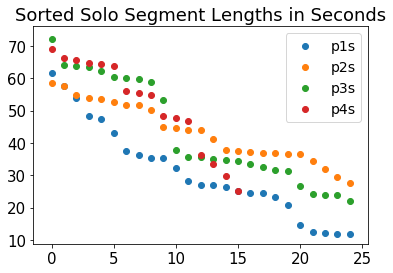

In [70]:
beats = {}
for key in queryInfo:
    if 's' in key:
        data = queryInfo[key]
        for segment in data:
            beat1 = segment.split(",")[0][1:]
            beat2 = segment.split(",")[1][:-1]
            if key in beats:
                beats[key].append((beat1,beat2))
            else:
                beats[key] = [(beat1,beat2)]
times={}
for key in timeData:
    pieceName = key.split("_")[0]
    if 's' in pieceName:
        for beat1, beat2 in beats[pieceName]:
            t1 = timeData[key][beat1]
            t2 = timeData[key][beat2]
            if pieceName in times:
                times[pieceName].append(t2-t1)
            else:
                times[pieceName]=[t2-t1]
for key in times:
    plt.scatter(np.arange(len(times[key])),sorted(times[key])[::-1], label = '{}'.format(key))
plt.legend(loc="upper right",fontsize = 14)
plt.title("Sorted Solo Segment Lengths in Seconds")

In [ ]:
beats = {}
for key in audioFiles:
    if 's' in key:
        for audio in audioFiles[key]
    